# Familiarisation avec les données

## Deux types de données
 
**Raster**:

* utilise une matrice de zones carrées, des pixels, dont la taille détermine le détail qui peut être conservé dans le jeu de données
* la valeur d'un pixel peut être continue (ex: altitude) ou catégorielle (ex: utilisation des terres)
* décrit l'intérieur des entitiés cartographiques
* utile pour capturer, stocker et analyser des données qui varient continuellement d'un endroit à l'autre (altitude, température, pH du sol, etc.)

**Vector**:

* utilise des coordonnées _x_ et _y_ pour définir la forme et l'emplacement des zones correspondant aux entités cartographiques
* un vecteur peut être un point (ex: point d'intérêt), une ligne (ex: route) ou un polygone (ex: lac)
* décrit le centre et les bords des entités
* utile pour capturer et stocker des détails spatiaux

https://mapasyst.extension.org/what-is-the-difference-between-raster-and-vector-data/#:~:text=Vector%20data%20are%20excellent%20for,store%20aerial%20and%20satellite%20imagery.

https://carpentries-incubator.github.io/geospatial-python/aio/index.html

## De quelles informations disposons-nous ?

Voir _V. Product description_ du manuel d'utilisation, en particulier _V.I.II. Nomenclature_ et _V.II. CLC status layer products_.

## Importation des données

In [112]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import shapely
import pandas as pd
from shapely.geometry import mapping
import rioxarray as rxr
import fiona

### Vector

In [113]:
# clc = gpd.read_file("data/u2018_clc2018_v2020_20u1_geoPackage/DATA/U2018_CLC2018_V2020_20u1.gpkg")

Impossible de lire tout le fichier _.gpkg_ d'un coup car le programme plante. J'en extrais donc des zones manuellement à l'aide de `QGIS`.


In [114]:
zones = fiona.listlayers("data/zones.gpkg")
zones

['zone-21',
 'zone-22',
 'zone-31',
 'zone-32',
 'zone-12',
 'zone-13',
 'zone-41',
 'zone-51',
 'zone-52',
 'zone-61',
 'zones-71',
 'zone-11']

In [115]:
zone_11_gdf = gpd.read_file("data/zones.gpkg", layer="zone-11")
zone_11_gdf.head()

,OBJECTID,Code_18,Remark,Area_Ha,ID,geometry
0,458367,111,None,32.684892,EU_458367,"MULTIPOLYGON (((3764057.100 2879442.440, 37638..."
1,464474,112,None,674.856306,EU_464474,"MULTIPOLYGON (((3772518.090 2869459.160, 37724..."
2,464486,112,None,125.582284,EU_464486,"MULTIPOLYGON (((3751235.850 2867880.030, 37509..."
3,464494,112,None,44.825253,EU_464494,"MULTIPOLYGON (((3753121.110 2869761.200, 37531..."
4,464503,112,None,30.711344,EU_464503,"MULTIPOLYGON (((3749222.430 2870367.950, 37491..."


In [116]:
zone_11_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 692 entries, 0 to 691
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   OBJECTID  692 non-null    int64   
 1   Code_18   692 non-null    object  
 2   Remark    0 non-null      object  
 3   Area_Ha   692 non-null    float64 
 4   ID        692 non-null    object  
 5   geometry  692 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(3)
memory usage: 32.6+ KB


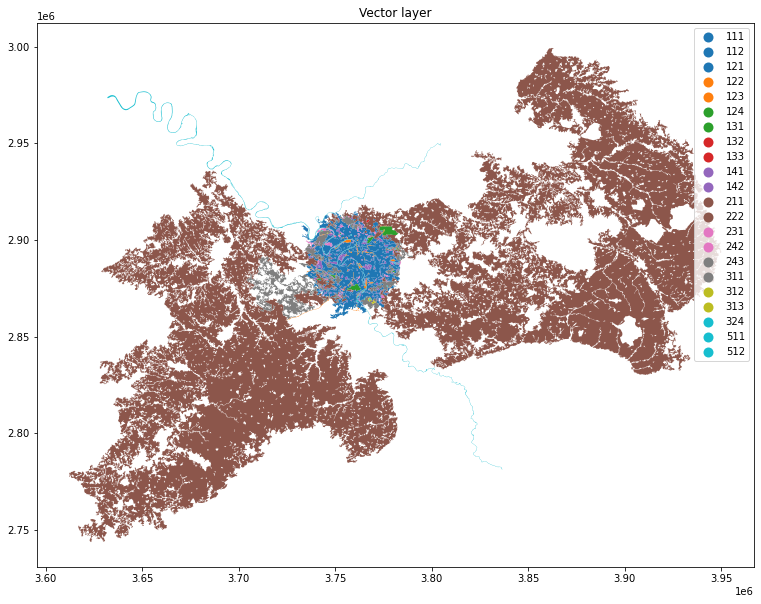

In [117]:
zone_11_gdf.plot(column="Code_18", legend=True, figsize=(20, 10))
plt.title("Vector layer")
plt.show()

#### Codes

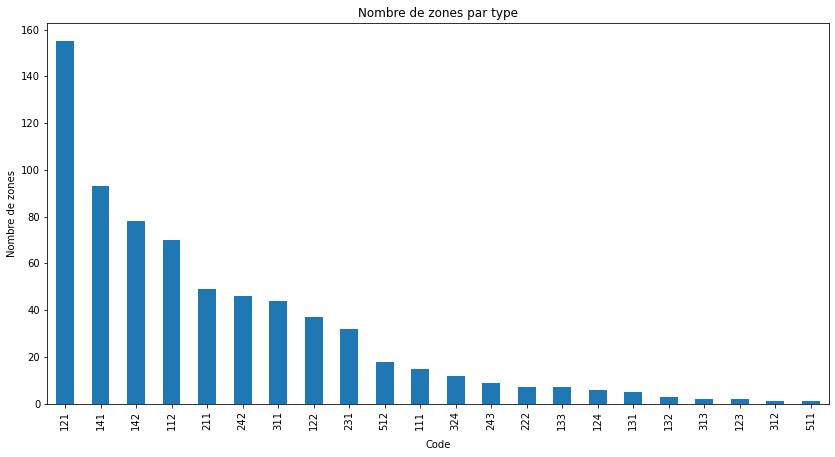

In [118]:
zone_11_gdf.Code_18.value_counts().plot(kind="bar", figsize=(14, 7))
plt.xlabel("Code",  labelpad=10)
plt.ylabel("Nombre de zones")
plt.title("Nombre de zones par type");

In [119]:
# nodata
zone_11_gdf[zone_11_gdf.Code_18 == "511"]

,OBJECTID,Code_18,Remark,Area_Ha,ID,geometry
691,597383,511,None,13039.815856,EU_597383,"MULTIPOLYGON (((3652488.790 2976715.870, 36524..."


#### Area

In [120]:
zone_11_gdf.Area_Ha.describe()

count    6.920000e+02
mean     3.730443e+03
std      6.120669e+04
min      2.502368e+01
25%      3.299732e+01
50%      5.519455e+01
75%      1.256282e+02
max      1.140250e+06
Name: Area_Ha, dtype: float64

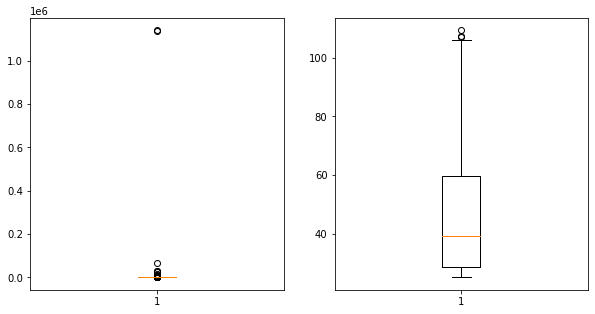

In [121]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.boxplot(zone_11_gdf.Area_Ha)
plt.subplot(122)
plt.boxplot(zone_11_gdf.Area_Ha[zone_11_gdf.Area_Ha < 110])
plt.show()

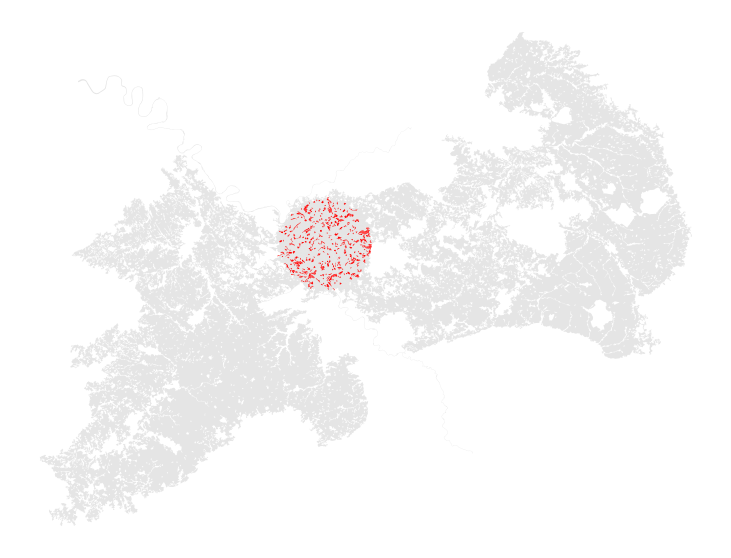

In [122]:
zone_11_gdf_area_low = zone_11_gdf[zone_11_gdf.Area_Ha < 125]
zone_11_gdf_area_high = zone_11_gdf[zone_11_gdf.Area_Ha >= 125]
f, ax = plt.subplots(figsize=(20, 10))
zone_11_gdf_area_low.plot(ax=ax, color = "red")
zone_11_gdf_area_high.plot(ax=ax, color="black", alpha = 0.1)
ax.set_axis_off()
plt.show()

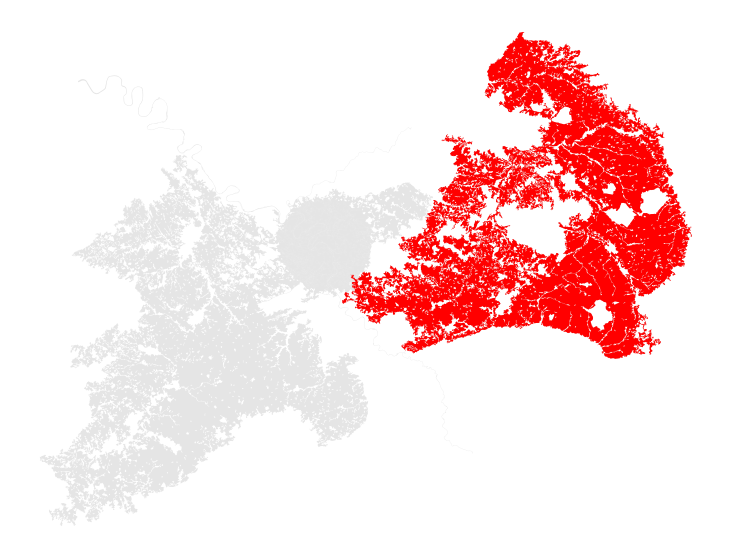

In [123]:
f, ax = plt.subplots(figsize=(20, 10))

zone_11_gdf.plot(ax=ax, color = "black", alpha = 0.1)
zone_11_gdf[zone_11_gdf.Area_Ha == max(zone_11_gdf.Area_Ha)].plot(ax=ax, color = "red")
ax.set_axis_off()
plt.show()

### Raster

In [124]:
attributes = gpd.read_file("data/clc/u2018_clc2018_v2020_20u1_raster100m/DATA/U2018_CLC2018_V2020_20u1.tif.vat.dbf")
attributes

,Value,Count,LABEL3,Red,Green,Blue,CODE_18,geometry
0,1,800699.0,Continuous urban fabric,0.901961,0.000000,0.301961,111,None
1,2,17085234.0,Discontinuous urban fabric,1.000000,0.000000,0.000000,112,None
2,3,3210212.0,Industrial or commercial units,0.800000,0.301961,0.949020,121,None
3,4,414626.0,Road and rail networks and associated land,0.800000,0.000000,0.000000,122,None
4,5,122685.0,Port areas,0.901961,0.800000,0.800000,123,None
5,6,352020.0,Airports,0.901961,0.800000,0.901961,124,None
6,7,820443.0,Mineral extraction sites,0.650980,0.000000,0.800000,131,None
7,8,125373.0,Dump sites,0.650980,0.301961,0.000000,132,None
8,9,201018.0,Construction sites,1.000000,0.301961,1.000000,133,None
9,10,330596.0,Green urban areas,1.000000,0.650980,1.000000,141,None


Les données raster contiennent les attributs rouge, vert et bleu mais pas infrarouge.

Geopandas ne gère pas les données raster, il faut un outil pour les exploiter: `rioxarray`.

À l'aide de QGIS, j'ai extrait manuellement une zone de la carte complète qui contient celle du jeu de données vectoriel.

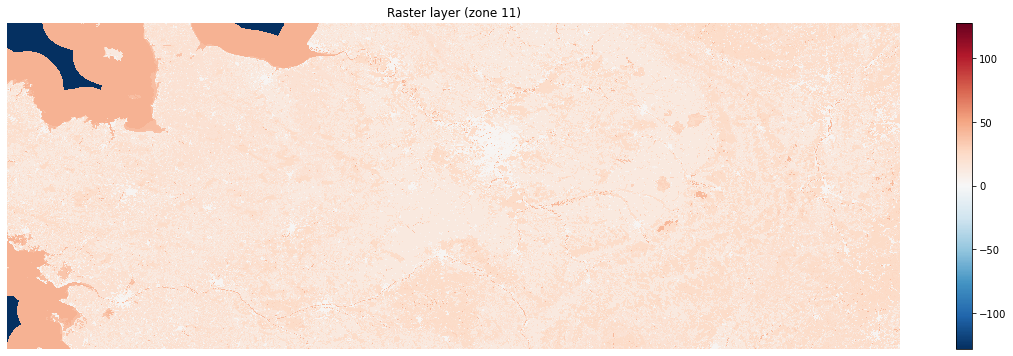

In [125]:
# raster = rxr.open_rasterio('data/zone-11.tif', masked=True).squeeze()
raster = rxr.open_rasterio('data/zone-11.tif').squeeze()

f, ax = plt.subplots(figsize=(20, 6))
raster.plot.imshow(ax=ax)
ax.set(title="Raster layer (zone 11)")
ax.set_axis_off()
plt.show()

**Interrogation**: à quoi servent les autres données (`U2018_CLC2018_V2020_20u1.tif.ovr`, `U2018_CLC2018_V2020_20u1.tfw`...) ?

### Association vector - raster

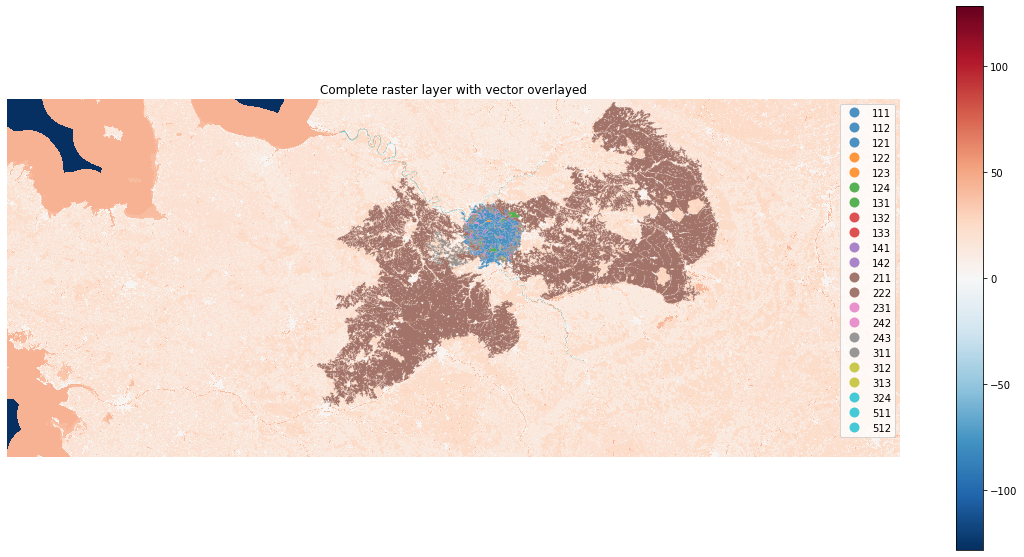

In [126]:
f, ax = plt.subplots(figsize=(20, 10))
raster.plot.imshow(ax=ax)
zone_11_gdf.plot(column="Code_18", legend=True, ax=ax, alpha=.8)
ax.set(title="Complete raster layer with vector overlayed")
ax.set_axis_off()
plt.show()

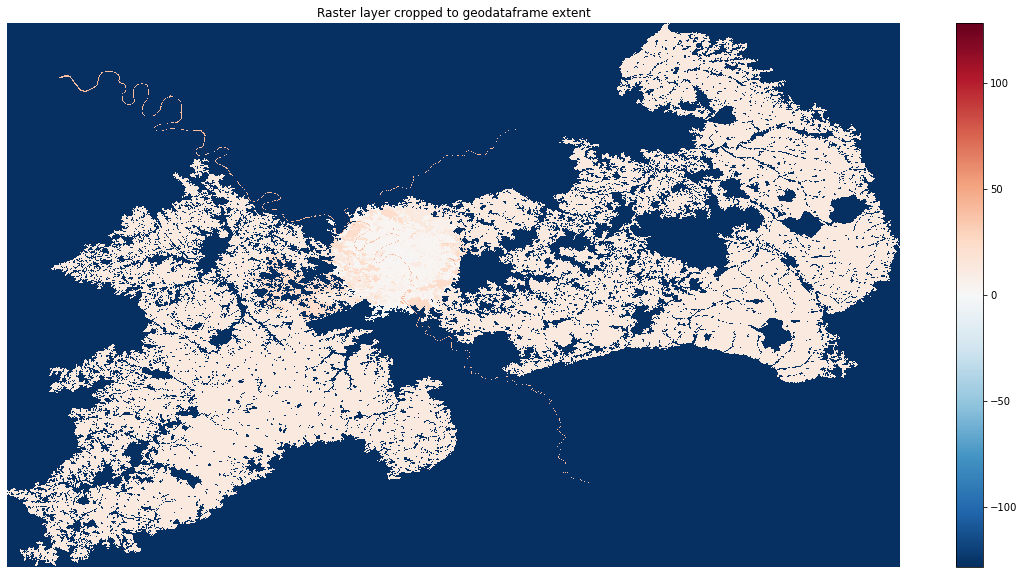

In [127]:
raster_clipped = raster.rio.clip(zone_11_gdf.geometry.apply(mapping),
                                 # This is needed if your zone_11_gdf is in a diff CRS than the raster data
                                 zone_11_gdf.crs)

f, ax = plt.subplots(figsize=(20, 10))
raster_clipped.plot(ax=ax)
ax.set(title="Raster layer cropped to geodataframe extent")
ax.set_axis_off()
plt.show()

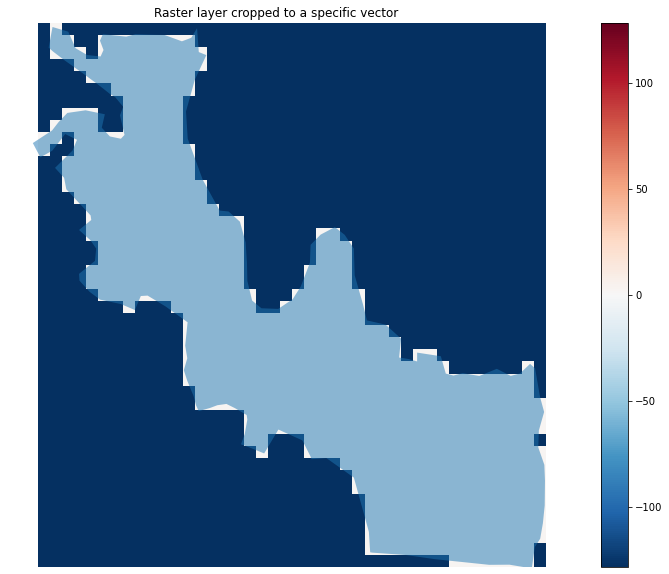

In [128]:
test = raster.rio.clip(zone_11_gdf.geometry[1].geoms)

f, ax = plt.subplots(figsize=(20, 10))

test.plot.imshow(ax=ax)

zone_11_gdf.loc[[1], 'geometry'].plot(ax=ax, alpha=.5)

ax.set(title="Raster layer cropped to a specific vector")

ax.set_axis_off()
plt.show()

Les données raster n'ont finalement pas l'air d'ếtre intéressantes à exploiter car on ne dispose pas de données RGB propres à chaque pixel. En effet, il semble que l'on dispose uniquement de valeurs RGB associées de manière générale aux codes CLC.

## Construction du graphe

In [129]:
import dgl
from dgl.data import DGLDataset
import torch
import networkx as nx
import matplotlib.image as mpimg
import os

### Prétraitement des données

In [130]:
def preprocessing(gdf):
    # utilisation de l'aire calculée par geopandas
    gdf.Area_Ha = gdf.area/1e4
    gdf.Code_18 = gdf.Code_18.astype(int)
    # pour simplifier la création des graphes
    gdf["Node_ID"] = gdf.index
    # todo : gérer les nodata
    # todo : ajouter les données intéressantes pour le graphe (par ex: gdf.length)
    return gdf

In [131]:
zone_11_gdf = preprocessing(zone_11_gdf)
zone_11_gdf.to_file("data/zone-11-preprocessed.gpkg", driver='GPKG')
zone_11_gdf.head()

/home/massimo/anaconda3/envs/graph/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


#### Voisinage

##### Vérifications : distance et superposition

Vérifions que les surfaces voisines se touchent et ne se superposent pas.

In [ ]:
def calc_dist_over(zones):
    distanced = pd.DataFrame(columns=["zone", "src", "dest", "distance"])
    overlapped = pd.DataFrame(columns=["zone", "src", "dest"])

    for zone in zones:
        gdf = gpd.read_file("data/zones.gpkg", layer=zone)
        print(f"{zone} ({gdf.shape[0]} instances)")

        for index, area in gdf.iterrows():
            distances = gdf.geometry.distance(area.geometry)

            neighbors_d = gdf[(distances < 10) & (distances != 0) & (gdf.OBJECTID != area.OBJECTID)]
            zone_d = [zone] * neighbors_d.shape[0]
            src_d = [area.OBJECTID] * neighbors_d.shape[0]
            dest_d = neighbors_d.OBJECTID.tolist()
            d = distances[neighbors_d.index].tolist()

            neighbors_o = gdf[(distances == 0) & (gdf.OBJECTID != area.OBJECTID)]
            neighbors_o =neighbors_o[neighbors_o.geometry.overlaps(area.geometry)]
            zone_o = [zone] * neighbors_o.shape[0]
            src_o = [area.OBJECTID] * neighbors_o.shape[0]
            dest_o = neighbors_o.OBJECTID.tolist()

            distanced = pd.concat([distanced, pd.DataFrame({"zone": zone_d, "src":src_d, "dest": dest_d, "distance":d})])
            overlapped = pd.concat([overlapped, pd.DataFrame({"zone": zone_o, "src":src_o, "dest": dest_o})])

        print("[ok] " + zone)

    print("finished")
    return distanced, overlapped

In [ ]:
distanced, overlapped = calc_dist_over(zones)

In [ ]:
distanced.to_csv("data/distanced.csv")
overlapped.to_csv("data/overlapped.csv")

In [ ]:
overlapped

Sur l'ensemble des données testées, il n'y a pas de surfaces qui se superposent. On considèrera donc qu'il n'y a pas de surfaces qui se superposent sur la totalité du jeu de données pour la suite.

In [ ]:
distanced

Il semble y avoir des couples de voisins légèrement éloignés, mais il faut vérifier qu'ils sont effectivement voisins en vérifiant qu'il n'y a pas un autre terrain entre les deux par exemple.

In [ ]:
def plot_distanced_neighbors(distanced):
    plt.figure(figsize=(20, 10))
    plt.subplots_adjust(hspace=0.5)

    i = 0
    src = []
    for index, neighbors in distanced.iterrows():
        if neighbors.dest in src:
            continue

        src.append(neighbors.src)

        # add a new subplot iteratively
        ax = plt.subplot(int(distanced.shape[0]/4)+1, 4, i + 1)
        i = i+1

        gdf = gpd.read_file("data/zones.gpkg", layer=neighbors.zone)
        areas = gdf[gdf.OBJECTID.isin([neighbors.src, neighbors.dest])]
        areas.plot(color = "red", ax=ax)

        other = gdf[gdf.geometry.touches(areas.iloc[0].geometry)]
        if other.shape[0] > 0:
            other.plot(color="grey", ax=ax)
        # chart formatting
        ax.set_title(f"Neighbors {neighbors.src} - {neighbors.dest}")

##### Calcul du voisinage

In [133]:
def preprocess_border(border):
    # plusieurs frontières
    if border.geom_type == "MultiLineString":
        border = shapely.ops.linemerge(border)
    return border

def calc_borders(area, neighbors):
    borders_info = {"total_borders":[], "greatest_borders":[], "nb_borders":[]}
    borders = neighbors.geometry.intersection(area.geometry)
    for border in borders:
        border = preprocess_border(border)
        if border.geom_type == "MultiLineString":
            lengths = gpd.GeoSeries(border.geoms).length
            borders_info["total_borders"].append(lengths.sum())
            borders_info["greatest_borders"].append(max(lengths))
            borders_info["nb_borders"].append(len(lengths))
        else:
            length = border.length
            borders_info["total_borders"].append(length)
            borders_info["greatest_borders"].append(length)
            borders_info["nb_borders"].append(1)
    return borders_info

def calc_neighborhood(gdf):
    neighbors_df = pd.DataFrame(columns=["src", "dest", "total_border", "greatest_border", "nb_border"])

    for index, area in gdf.iterrows():
        print(f"{index}", end=" ")

        neighbors = gdf[gdf.geometry.touches(area.geometry)]

        src = [area.Node_ID] * neighbors.shape[0]
        dest = neighbors.Node_ID.tolist()

        borders = calc_borders(area, neighbors)

        df = pd.DataFrame({"src":src, "dest": dest, "total_border": borders["total_borders"], "greatest_border": borders["greatest_borders"], "nb_border": borders["nb_borders"]})

        neighbors_df = pd.concat([neighbors_df, df])

    print("finished")

    return neighbors_df

In [134]:
neighborhood = calc_neighborhood(zone_11_gdf)
neighborhood.to_csv("data/zone-11-neighborhood.csv")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [135]:
neighborhood.head()

,src,dest,total_border,greatest_border,nb_border
0,0,56,202.413571,202.413571,1
1,0,662,1851.487084,1851.487084,1
2,0,671,571.23882,571.23882,1
3,0,691,441.460743,441.460743,1
0,1,86,6967.211402,5415.288413,2


### Classification de graphe

In [141]:
class GraphClassificationDataset(DGLDataset):
    def __init__(self):
        super().__init__(name='synthetic')

    def process(self):
        gdf = gpd.read_file("data/zone-11-preprocessed.gpkg")
        neighborhood = pd.read_csv("data/zone-11-neighborhood.csv")
        self.labels = []
        self.graphs = []

        neighbors_group = neighborhood.groupby('src')
        for graph_id in neighbors_group.groups:
            # Find the edges as well as the number of nodes and its label.
            neighbors = neighbors_group.get_group(graph_id)
            num_nodes = len(neighbors) + 1

            nodes_data = gdf[gdf.Node_ID.isin(neighbors.dest.tolist())]
            nodes_data = gpd.GeoDataFrame(pd.concat([gdf[gdf.Node_ID == graph_id], nodes_data]))

            src_nodes = np.zeros(len(neighbors))
            dest_nodes = np.arange(1,num_nodes)

            g = dgl.graph((src_nodes, dest_nodes), num_nodes=num_nodes)
            g.ndata['label'] = torch.from_numpy(nodes_data.OBJECTID.to_numpy())
            g.ndata['area'] = torch.from_numpy(nodes_data.Area_Ha.to_numpy())
            g.ndata['code'] = torch.from_numpy(nodes_data.Code_18.to_numpy())
            g.edata['total_border'] = torch.from_numpy(neighbors.total_border.to_numpy())
            g.edata['greatest_border'] = torch.from_numpy(neighbors.greatest_border.to_numpy())
            g.edata['nb_border'] = torch.from_numpy(neighbors.nb_border.to_numpy())

            self.graphs.append(g)
            self.labels.append(nodes_data.iloc[0].OBJECTID)

        # convert the label list to tensor for saving.
        self.labels = torch.LongTensor(self.labels)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

In [142]:
graph_classification_dataset = GraphClassificationDataset()

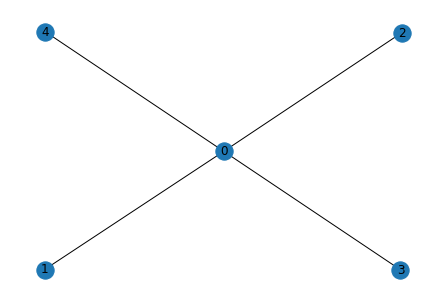

In [143]:
g, label = graph_classification_dataset[0]
g_nx = dgl.to_networkx(g, node_attrs=g.ndata.keys(), edge_attrs=g.edata.keys()).to_undirected()
nx.draw(g_nx, with_labels=True)

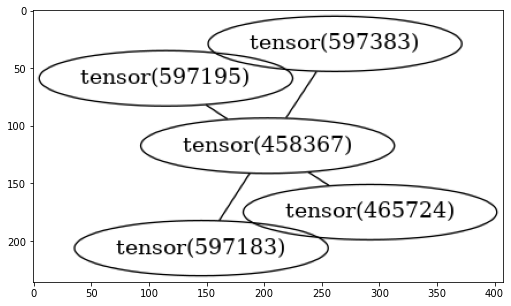

In [144]:
path = './a.out.png'

ag = nx.nx_agraph.to_agraph(g_nx)
ag.layout()
ag.draw(path)

img = mpimg.imread(path)
plt.figure(figsize=(10,5))
plt.imshow(img)
plt.show()

os.remove(path)

In [55]:
# autres exportations
# nx.write_graphml(g_nx, "test.graphml") # peut être utilisé avec cytoscape
# nx.drawing.nx_agraph.write_dot(g_nx, "test.dot") # dot file

### Classification de noeud

In [145]:
class NodeClassificationDataset(DGLDataset):
    def __init__(self):
        super().__init__(name='karate_club')

    def process(self):
        nodes_data = gpd.read_file("data/zone-11-preprocessed.gpkg")
        neighborhood = pd.read_csv("data/zone-11-neighborhood.csv")

        src_nodes = neighborhood.src
        dest_nodes = neighborhood.dest
        num_nodes = nodes_data.shape[0]

        self.graph = dgl.graph((src_nodes, dest_nodes), num_nodes=num_nodes)

        self.graph.ndata['label'] = torch.from_numpy(nodes_data.OBJECTID.to_numpy())
        self.graph.ndata['area'] = torch.from_numpy(nodes_data.Area_Ha.to_numpy())
        self.graph.ndata['code'] = torch.from_numpy(nodes_data.Code_18.to_numpy())
        self.graph.edata['total_border'] = torch.from_numpy(neighborhood.total_border.to_numpy())
        self.graph.edata['greatest_border'] = torch.from_numpy(neighborhood.greatest_border.to_numpy())
        self.graph.edata['nb_border'] = torch.from_numpy(neighborhood.nb_border.to_numpy())

        # masks indicating whether a node belongs to training, validation, and test set
        n_train = int(num_nodes * 0.6)
        n_val = int(num_nodes * 0.2)
        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        val_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)
        train_mask[:n_train] = True
        val_mask[n_train:n_train + n_val] = True
        test_mask[n_train + n_val:] = True
        self.graph.ndata['train_mask'] = train_mask
        self.graph.ndata['val_mask'] = val_mask
        self.graph.ndata['test_mask'] = test_mask

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

In [146]:
node_classification_dataset = NodeClassificationDataset()

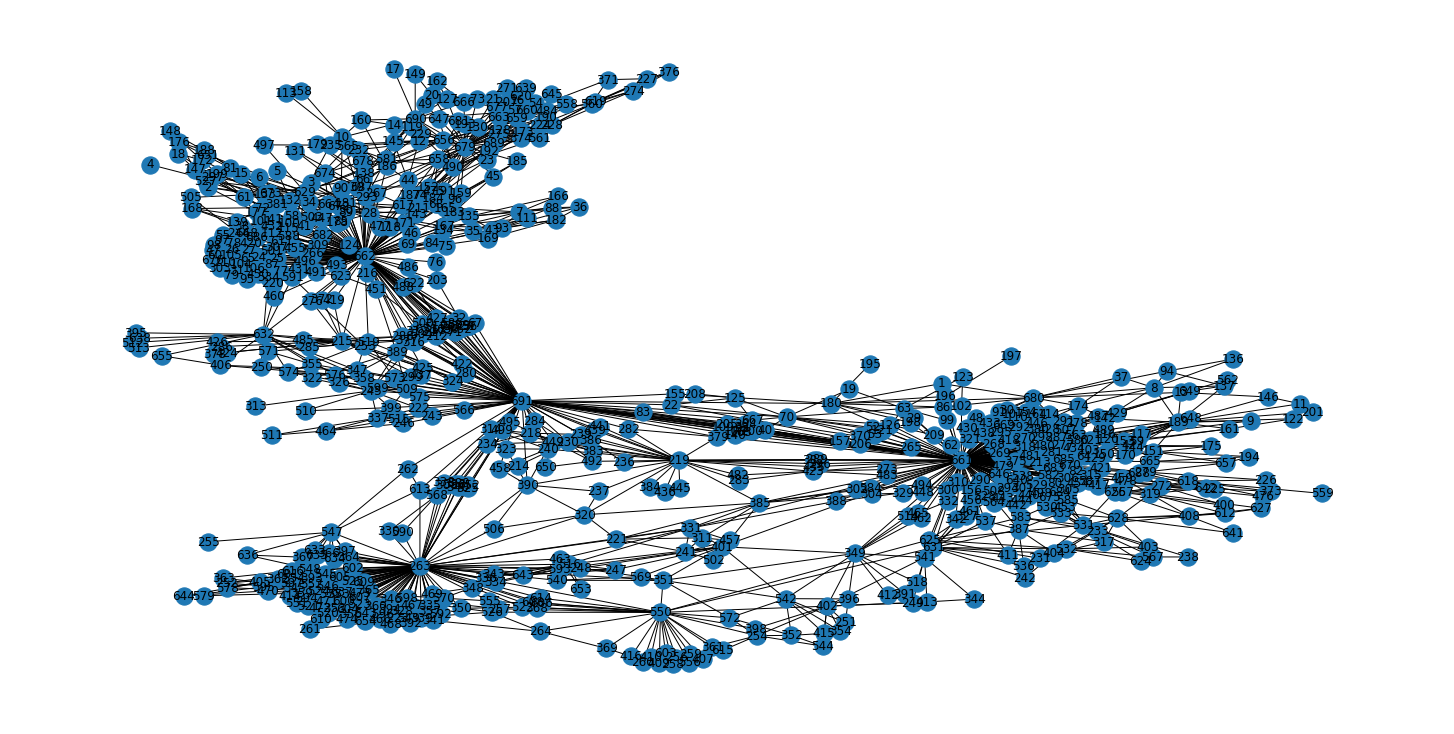

In [147]:
g = node_classification_dataset[0]
plt.figure(figsize=(20,10))
g_nx = dgl.to_networkx(g, node_attrs=g.ndata.keys(), edge_attrs=g.edata.keys()).to_undirected()
nx.draw(g_nx, with_labels=True)

## Extraction de zones géographiques

L'extraction manuelle des zones à l'aide de QGIS est trop fastidieuse, il faut un moyen d'automatiser le processus. En plus, cette méthode n'est pas précise. Geopandas donne la possibilité de charger uniquement une partie du jeu de données complet en fonction de coordonnées données. C'est ce que nous allons utiliser.

Le module GeoPy, intégré au sein de Geopandas, permet de convertir un nom en coordonnées géographiques. À partir de ce point, nous pouvons créer une zone avec un certain rayon et extraire la partie du jeu de données complet qui lui correspond.

Des sites comme http://www.geonames.org/ permettent aussi de récupérer des coordonnées géographiques à partir d'un nom


In [63]:
paris_location = gpd.tools.geocode("Paris")
paris_location

,geometry,address
0,POINT (2.32004 48.85889),"Paris, 75000;75001;75002;75003;75004;75005;750..."


In [45]:
paris_area = paris_location.geometry.buffer(10)

/tmp/ipykernel_27162/1448691870.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  paris_area = paris_location.geometry.buffer(10)


In [46]:
paris_location.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [47]:
zone_11_gdf.crs

<Derived Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Turkey; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Europ

In [48]:
paris_location_projected = paris_location.to_crs(epsg=3035)

In [110]:
paris_area = paris_location_projected.geometry.buffer(40000)
paris_area

0    POLYGON ((3798451.870 2889983.454, 3798259.259...
dtype: geometry

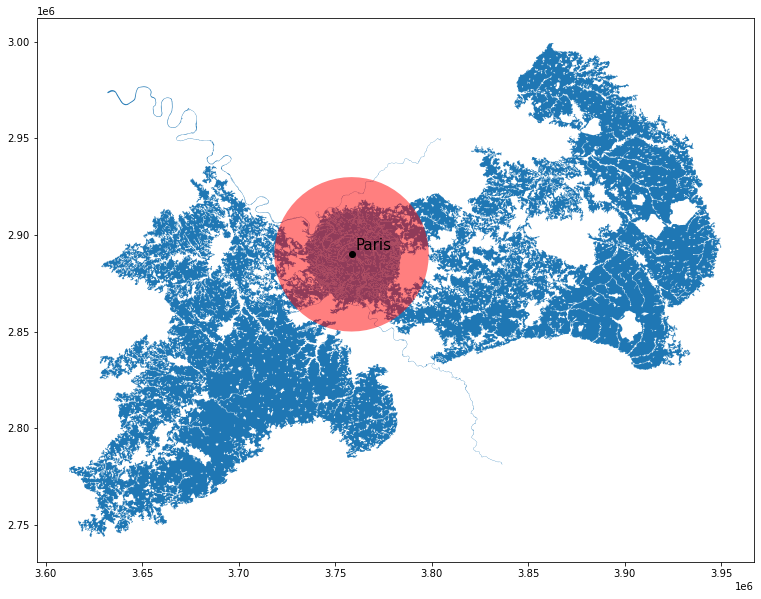

In [111]:
f,ax = plt.subplots(figsize=(20,10))
zone_11_gdf.plot(ax=ax)
paris_area.plot(ax=ax, color="red", alpha=0.5)
center = paris_area.geometry.centroid
center.plot(ax=ax, color="black", label="Paris")
plt.annotate("Paris", xy=(center.x, center.y), xytext=(center.x + 2000, center.y + 2000), color="black", fontsize = 15)
plt.show()

Remarque : puisque les capitales ne sont pas de même taille, on prendra des petites zones pour augmenter les chances de ne pas prendre des terrains non urbains.

On a réussi à créer une zone à partir d'un nom de ville, on peut maintenant extraire les données correspondantes à partir du jeu de données complet

In [148]:
paris_gdf = gpd.read_file("data/clc/u2018_clc2018_v2020_20u1_geoPackage/DATA/U2018_CLC2018_V2020_20u1.gpkg", mask=paris_area)

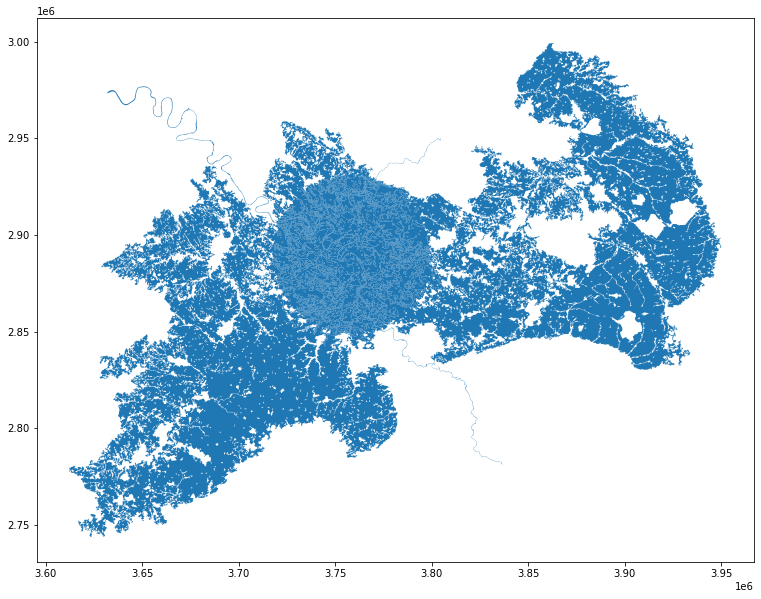

In [151]:
paris_gdf.plot(figsize=(20,10))
plt.show()

On retrouve bien la même région de la carte que celle extraite manuellement.